# Problem 2: Basics of Neural Networks
* <b>Learning Objective:</b> In this problem, you are asked to implement a basic multi-layer fully connected neural network from scratch, including forward and backward passes of certain essential layers, to perform an image classification task on the CIFAR-10 dataset. You need to implement essential functions in different indicated python files under directory `lib`. You can use the intermediate results printed in the notebook to check your answer. Include the outputs of ALL cells in the submitted python notebook.
* <b>Provided Code:</b> We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* <b>TODOs:</b> You are asked to implement the forward passes and backward passes for standard layers and loss functions, various widely-used optimizers, and part of the training procedure. And finally we want you to train a network from scratch on your own.

In [3]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.train import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (CIFAR-10)

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a well known dataset composed of 60,000 colored 32x32 images. The utility function `cifar10()` returns the entire CIFAR-10 dataset as a set of six numpy arrays:
* `x_train` contains all training images (real numbers in the range  [0,1] )
* `y_train` contains all training labels (integers in the range  [0,9] )
* `x_test` contains all test images
* `y_test` contains all test labels
* `x_val` contains all validation images
* `y_val` contains all validation labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [4]:
import os
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split


def _extract_arrays(dset):
    x = np.divide(dset.data, 255, dtype=np.float32)
    y = np.array(dset.targets, dtype=np.int64)
    return x, y


def cifar10():
    download = not os.path.isdir("cifar-10-batches-py")
    dset_train = CIFAR10(root=".", download=download, train=True)
    dset_test = CIFAR10(root=".", train=False)
    x_train, y_train = _extract_arrays(dset_train)
    x_test_val, y_test_val = _extract_arrays(dset_test)
    x_test, x_val, y_test, y_val = train_test_split(
        x_test_val, y_test_val, test_size=0.2
    )
    return x_train, y_train, x_test, y_test, x_val, y_val

In [5]:
x_train, y_train, x_test, y_test, x_val, y_val = cifar10()

data = {
    "data_train": x_train,
    "labels_train": y_train,
    "data_val": x_test,
    "labels_val": y_test,
    "data_test": x_val,
    "labels_test": y_val,
}

for k, v in data.items():
    print("Name: {} Shape: {}".format(k, v.shape))

Name: data_train Shape: (50000, 32, 32, 3)
Name: labels_train Shape: (50000,)
Name: data_val Shape: (8000, 32, 32, 3)
Name: labels_val Shape: (8000,)
Name: data_test Shape: (2000, 32, 32, 3)
Name: labels_test Shape: (2000,)


## Implement Standard Layers
You will now implement all the following standard layers commonly seen in a fully connected neural network (aka multi-layer perceptron, MLP). Please refer to the file `lib/mlp/layer_utils.py`. Take a look at each class skeleton, and we will walk you through the network layer by layer. We provide results of some examples we pre-computed for you for checking the forward pass, and also the gradient checking for the backward pass.

## FC Forward 
In the class skeleton `flatten` and `fc` in `lib/mlp/layer_utils.py`, please complete the forward pass in function `forward`. The input to the `fc` layer may not be of dimension (batch size, features size), it could be an image or any higher dimensional data. We want to convert the input to have a shape of (batch size, features size). Make sure that you handle this dimensionality issue. 

In [6]:
%reload_ext autoreload

# Test the fc forward function
input_bz = 3 # batch size
input_dim = (7, 6, 4)
output_dim = 4

input_size = input_bz * np.prod(input_dim)
weight_size = output_dim * np.prod(input_dim)

flatten_layer = flatten(name="flatten_test")
single_fc = fc(np.prod(input_dim), output_dim, init_scale=0.02, name="fc_test")

x = np.linspace(-0.1, 0.4, num=input_size).reshape(input_bz, *input_dim)
w = np.linspace(-0.2, 0.2, num=weight_size).reshape(np.prod(input_dim), output_dim)
b = np.linspace(-0.3, 0.3, num=output_dim)

single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

out = single_fc.forward(flatten_layer.forward(x))

correct_out = np.array([[0.63910291, 0.83740057, 1.03569824, 1.23399591],
                        [0.61401587, 0.82903823, 1.04406058, 1.25908294],
                        [0.58892884, 0.82067589, 1.05242293, 1.28416997]])

# Compare your output with the above pre-computed ones.
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Difference:  4.0260162945880345e-09


## FC Backward
Please complete the function `backward` as the backward pass of the `flatten` and `fc` layers. Follow the instructions in the comments to store gradients into the predefined dictionaries in the attributes of the class. Parameters of the layer are also stored in the predefined dictionary.

In [20]:
%reload_ext autoreload

# Test the fc backward function
inp = np.random.randn(15, 2, 2, 3)
w = np.random.randn(12, 15)
b = np.random.randn(15)
dout = np.random.randn(15, 15)

flatten_layer = flatten(name="flatten_test")
x = flatten_layer.forward(inp)
single_fc = fc(np.prod(x.shape[1:]), 15, init_scale=5e-2, name="fc_test")
single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

dx_num = eval_numerical_gradient_array(lambda x: single_fc.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_fc.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_fc.forward(x), b, dout)

out = single_fc.forward(x)
dx = single_fc.backward(dout)
dw = single_fc.grads[single_fc.w_name]
db = single_fc.grads[single_fc.b_name]
dinp = flatten_layer.backward(dx)

# The error should be around 1e-9
print("dx Error: ", rel_error(dx_num, dx))
# The errors should be around 1e-10
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dinp Shape: ", dinp.shape, inp.shape)


# assert rel_error(dx_num, dx) < 1e-9
# assert rel_error(dw_num, dw) < 1e-10
# assert rel_error(db_num, db) < 1e-10

dx Error:  2.8693502017941162e-08
dw Error:  3.754987347389613e-07
db Error:  2.01092716720898e-11
dinp Shape:  (15, 2, 2, 3) (15, 2, 2, 3)


## Leaky ReLU Forward 
In the class skeleton `leaky_relu` in `lib/mlp/layer_utils.py`, please complete the `forward` pass.

A "leaky" ReLU is similar to a ReLU, but rather than zero-ing out features valued less than 0, they are multiplied by a constant value less than 1.

$$
LeakyReLU(x) = \begin{cases} x & x \geq 0 \\ c * x & x \lt 0 \\ \end{cases}\text{, where } 0 \leq c \lt 1
$$

When $c = 0$, a Leaky ReLU is equivalent to a standard ReLU.

In [17]:
%reload_ext autoreload

# Test the leaky_relu forward function
x = np.linspace(-1.5, 1.5, num=12).reshape(3, 4)
lrelu_f = leaky_relu(negative_slope=0.01, name="leaky_relu_f")

out = lrelu_f.forward(x)

correct_out = np.array([[-0.015,        -0.0122727273, -0.0095454545, -0.0068181818],
                        [-0.0040909091, -0.0013636364,  0.1363636364,  0.4090909091],
                        [ 0.6818181818,  0.9545454545,  1.2272727273,  1.5         ]])

# Compare your output with the above pre-computed ones.
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

assert rel_error(out, correct_out) < 1e-7

Difference:  1.3333332805929594e-08


## Leaky ReLU Backward 
Please complete the `backward` pass of the class `leaky_relu`.

In [16]:
%reload_ext autoreload

# Test the relu backward function
x = np.random.randn(15, 15)
dout = np.random.randn(*x.shape)
lrelu_b = leaky_relu(negative_slope=0.01, name="leaky_relu_b")

dx_num = eval_numerical_gradient_array(lambda x: lrelu_b.forward(x), x, dout)

out = lrelu_b.forward(x)
dx = lrelu_b.backward(dout)

# The error should not be larger than 1e-10
print ("dx Error: ", rel_error(dx_num, dx))

assert rel_error(dx_num, dx) < 1e-10


dx Error:  5.704229790014898e-12


## Dropout Forward
In the class `dropout` in `lib/mlp/layer_utils.py`, please complete the `forward` pass.  
Remember that the dropout is **only applied during training phase**, you should pay attention to this while implementing the function.
##### Important Note1: The probability argument input to the function is the "keep probability": probability that each activation is kept.
##### Important Note2: If the keep_prob is set to 0, make it as no dropout.

In [21]:
%reload_ext autoreload

x = np.random.randn(100, 100) + 5.0

print ("----------------------------------------------------------------")
for p in [0, 0.25, 0.50, 0.75, 1]:
    dropout_f = dropout(keep_prob=p)
    out = dropout_f.forward(x, True)
    out_test = dropout_f.forward(x, False)

    # Mean of output should be similar to mean of input
    # Means of output during training time and testing time should be similar
    print ("Dropout Keep Prob = ", p)
    print ("Mean of input: ", x.mean())
    print ("Mean of output during training time: ", out.mean())
    print ("Mean of output during testing time: ", out_test.mean())
    print ("Fraction of output set to zero during training time: ", (out == 0).mean())
    print ("Fraction of output set to zero during testing time: ", (out_test == 0).mean())
    print ("----------------------------------------------------------------")

----------------------------------------------------------------
Dropout Keep Prob =  0
Mean of input:  4.988817986122519
Mean of output during training time:  4.988817986122519
Mean of output during testing time:  4.988817986122519
Fraction of output set to zero during training time:  0.0
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout Keep Prob =  0.25
Mean of input:  4.988817986122519
Mean of output during training time:  4.929607887866016
Mean of output during testing time:  4.988817986122519
Fraction of output set to zero during training time:  0.7515
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout Keep Prob =  0.5
Mean of input:  4.988817986122519
Mean of output during training time:  4.974797345473869
Mean of output during testing time:  4.988817986122519
Fraction of output set to zero during training time:  0.5017
Fr

## Dropout Backward 
Please complete the `backward` pass. Again remember that the dropout is only applied during training phase, handle this in the backward pass as well.

In [108]:
%reload_ext autoreload

x = np.random.randn(5, 5) + 5
dout = np.random.randn(*x.shape)

keep_prob = 0.75
dropout_b = dropout(keep_prob, seed=100)
out = dropout_b.forward(x, True, seed=1)
dx = dropout_b.backward(dout)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_b.forward(xx, True, seed=1), x, dout)

# The error should not be larger than 1e-10
print ('dx relative error: ', rel_error(dx, dx_num))

assert rel_error(dx, dx_num) < 1e-10

dx relative error:  3.00311037252675e-11


## Testing cascaded layers: FC + Leaky ReLU 
Please find the `TestFCReLU` function in `lib/mlp/fully_conn.py`. <br />
You only need to complete a few lines of code in the TODO block. <br />
Please design an `Flatten -> FC -> Leaky ReLU` network where the parameters of them match the given x, w, and b. <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. Here you only modify the param_name part, the `_w`, and `_b` are automatically assigned during network setup 

In [26]:
%reload_ext autoreload

x = np.random.randn(3, 5, 3)  # the input features
w = np.random.randn(15, 5)   # the weight of fc layer
b = np.random.randn(5)       # the bias of fc layer
dout = np.random.randn(3, 5) # the gradients to the output, notice the shape

tiny_net = TestFCReLU()

###################################################
# TODO: param_name should be replaced accordingly #
###################################################
tiny_net.net.assign("fc_testfc_w", w)
tiny_net.net.assign("fc_testfc_b", b)
###################################################
#                END OF YOUR CODE                 #
###################################################

out = tiny_net.forward(x)
dx = tiny_net.backward(dout)

###################################################
# TODO: param_name should be replaced accordingly #
###################################################
dw = tiny_net.net.get_grads("fc_testfc_w")
db = tiny_net.net.get_grads("fc_testfc_b")
###################################################
#                END OF YOUR CODE                 #
###################################################

dx_num = eval_numerical_gradient_array(lambda x: tiny_net.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: tiny_net.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: tiny_net.forward(x), b, dout)

# The errors should not be larger than 1e-7
print ("dx error: ", rel_error(dx_num, dx))
print ("dw error: ", rel_error(dw_num, dw))
print ("db error: ", rel_error(db_num, db))

assert rel_error(dx_num, dx) < 1e-7
assert rel_error(dw_num, dw) < 1e-7
assert rel_error(db_num, db) < 1e-7

dx error:  6.596498829065555e-11
dw error:  1.8274986072340715e-10
db error:  9.943511314229703e-12


## SoftMax Function and Loss Layer
In the `lib/mlp/layer_utils.py`, please first complete the function `softmax`, which will be used in the class `cross_entropy`. Then, implement `cross_entropy` using `softmax`.
Note that cross entropy of a single data sample is given by the following formula:

$\text{CE} = -\Sigma_{i=1}^k p_i log q_i$,
where $q_i$ is the predicted probability (obtained by softmax) of class $i$ and $p_i$ is the true probability (either 0 or 1 depending on $y$) of class $i$.

The cross entropy loss can be the sum or the mean over CE of all data samples. 

$\text{CE loss (sum)} = -\Sigma_{j=1}^N \Sigma_{i=1}^k p^{(j)}_i \log q^{(j)}_i$

$\text{CE loss (mean)} = -\frac{1}{N}\Sigma_{j=1}^N \Sigma_{i=1}^k p^{(j)}_i \log q^{(j)}_i$

The superscript $j$ indicates the index of the data sample.

The `cross_entropy` class has an argument `size_average` to select between the sum or the mean version of the CE loss.

In [119]:
%reload_ext autoreload

num_classes, num_inputs = 6, 100
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

test_loss = cross_entropy()

dx_num = eval_numerical_gradient(lambda x: test_loss.forward(x, y), x, verbose=False)
loss = test_loss.forward(x, y)
dx = test_loss.backward()
# Test cross entropy function. Loss should be around 1.792 (for the mean version)
# and dx error should be at the scale of 1e-8 (or smaller)
print ("Cross Entropy Loss: ", loss)
print ("dx error: ", rel_error(dx_num, dx))

assert rel_error(dx_num, dx) <  1e-8

Cross Entropy Loss:  1.7917319484364627
dx error:  8.09874375581348e-09


## Test a Small Fully Connected Network 
Please find the `SmallFullyConnectedNetwork` function in `lib/mlp/fully_conn.py`. <br />
Again you only need to complete few lines of code in the TODO block. <br />
Please design an `FC --> Leaky ReLU --> FC` network where the shapes of parameters match the given shapes. <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. <br />
Here you only modify the param_name part, the `_w`, and `_b` are automatically assigned during network setup. 

In [120]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = SmallFullyConnectedNetwork()
loss_func = cross_entropy()

N, D, = 4, 4  # N: batch size, D: input dimension
H, C  = 30, 7 # H: hidden dimension, C: output dimension
std = 0.02
x = np.random.randn(N, D)
y = np.random.randint(C, size=N)
print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("fc_sfcn1_w").std() - std)
b1 = model.net.get_params("fc_sfcn1_b").std()
w2_std = abs(model.net.get_params("fc_sfcn2_w").std() - std)
b2 = model.net.get_params("fc_sfcn2_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
w2 = np.linspace(-0.2, 0.2, num=H*C).reshape(H, C)
b1 = np.linspace(-0.6, 0.2, num=H)
b2 = np.linspace(-0.9, 0.1, num=C)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("fc_sfcn1_w", w1)
model.net.assign("fc_sfcn1_b", b1)
model.net.assign("fc_sfcn2_w", w2)
model.net.assign("fc_sfcn2_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.forward(feats)
correct_scores = np.asarray([[-2.33876804, -1.92168925, -1.50461046, -1.08753166, -0.67045287, -0.25337408,  0.16370472],
                             [-1.57216705, -1.18571026, -0.79925348, -0.4127967 , -0.02633991, 0.36011687,  0.74657365],
                             [-0.80556605, -0.44973128, -0.09389651,  0.26193827,  0.61777304, 0.97360782,  1.32944259],
                             [-0.03896506,  0.2862477 ,  0.61146047,  0.93667323,  1.261886  , 1.58709876,  1.91231153]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 5, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 2.4250083210516835
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
fc_sfcn1_b relative error: 4.54e-09
fc_sfcn1_w relative error: 7.91e-09
fc_sfcn2_b relative error: 1.29e-10
fc_sfcn2_w relative error: 2.36e-08


## Test a Fully Connected Network regularized with Dropout 
Please find the `DropoutNet` function in `fully_conn.py` under `lib/mlp` directory. <br />
For this part you don't need to design a new network, just simply run the following test code. <br />
If something goes wrong, you might want to double check your dropout implementation.

In [121]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

N, D, C = 3, 15, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for keep_prob in [0, 0.25, 0.5]:
    np.random.seed(seed=seed)
    print ("Dropout p =", keep_prob)
    model = DropoutNet(keep_prob=keep_prob, seed=seed)
    loss_func = cross_entropy()
    output = model.forward(X, True, seed=seed)
    loss = loss_func.forward(output, y)
    dLoss = loss_func.backward()
    dX = model.backward(dLoss)
    grads = model.net.grads

    print ("Error of gradients should be around or less than 1e-3")
    for name in sorted(grads):
        if name not in model.net.params.keys():
            continue
        f = lambda _: loss_func.forward(model.forward(X, True, seed=seed), y)
        grad_num = eval_numerical_gradient(f, model.net.params[name], verbose=False, h=1e-5)
        print ("{} relative error: {}".format(name, rel_error(grad_num, grads[name])))
    print ()

Dropout p = 0
Error of gradients should be around or less than 1e-3
fc1_b relative error: 1.7273340398130986e-06
fc1_w relative error: 9.723764019826069e-05
fc2_b relative error: 2.7841895282813544e-06
fc2_w relative error: 0.003922229784151283
fc3_b relative error: 6.9596628378975445e-09
fc3_w relative error: 0.00022432901231144177

Dropout p = 0.25
Error of gradients should be around or less than 1e-3
fc1_b relative error: 2.1950150912577644e-06
fc1_w relative error: 2.5552274041963864e-05
fc2_b relative error: 1.87808453437951e-06
fc2_w relative error: 0.001153520563130634
fc3_b relative error: 6.521995746108614e-10
fc3_w relative error: 0.00031318161857379944

Dropout p = 0.5
Error of gradients should be around or less than 1e-3
fc1_b relative error: 1.0575473869314446e-06
fc1_w relative error: 7.381101514054197e-05
fc2_b relative error: 1.743844393693493e-07
fc2_w relative error: 0.0017570024681554494
fc3_b relative error: 6.447435147462481e-10
fc3_w relative error: 3.584680630616

## Training a Network
In this section, we defined a `TinyNet` class for you to fill in the TODO block in `lib/mlp/fully_conn.py`.
* Here please design a two layer fully connected network with Leaky ReLU activation (`Flatten --> FC --> Leaky ReLU --> FC`).
* You can adjust the number of hidden neurons, batch_size, epochs, and learning rate decay parameters.
* Please read the `lib/train.py` carefully and complete the TODO blocks in the `train_net` function first. Codes in "Test a Small Fully Connected Network" can be helpful.
* In addition, read how the SGD function is implemented in `lib/optim.py`, you will be asked to complete three other optimization methods in the later sections.

In [122]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [123]:
print("Data shape:", data["data_train"].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (50000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 10


### Now train the network to achieve at least 50% validation accuracy 
You may only adjust the hyperparameters inside the TODO block

In [125]:
%reload_ext autoreload

model = TinyNet()
loss_f = cross_entropy()
optimizer = SGD(model.net, 1e-2)

results = None
#############################################################################
# TODO: Adjust these hyperparameters                                        #
#############################################################################
batch_size = 100
epochs = 50
lr_decay = .99
lr_decay_every = 50
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs,
                    lr_decay, lr_decay_every, show_every=10000, verbose=True)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

(Iteration 1 / 25000) loss: 2.299802287877944
(Epoch 1 / 50) Training Accuracy: 0.27598, Validation Accuracy: 0.273625
(Epoch 2 / 50) Training Accuracy: 0.3285, Validation Accuracy: 0.32575
(Epoch 3 / 50) Training Accuracy: 0.35104, Validation Accuracy: 0.350875
(Epoch 4 / 50) Training Accuracy: 0.36872, Validation Accuracy: 0.371125
(Epoch 5 / 50) Training Accuracy: 0.37854, Validation Accuracy: 0.378375
(Epoch 6 / 50) Training Accuracy: 0.38602, Validation Accuracy: 0.385
(Epoch 7 / 50) Training Accuracy: 0.40428, Validation Accuracy: 0.405875
(Epoch 8 / 50) Training Accuracy: 0.41804, Validation Accuracy: 0.41825
(Epoch 9 / 50) Training Accuracy: 0.42844, Validation Accuracy: 0.427625
(Epoch 10 / 50) Training Accuracy: 0.4346, Validation Accuracy: 0.432125
(Epoch 11 / 50) Training Accuracy: 0.4455, Validation Accuracy: 0.4445
(Epoch 12 / 50) Training Accuracy: 0.4537, Validation Accuracy: 0.444625
(Epoch 13 / 50) Training Accuracy: 0.44636, Validation Accuracy: 0.44325
(Epoch 14 / 5

In [126]:
# Take a look at what names of params were stored
print (opt_params.keys())

dict_keys(['tinyfc1_w', 'tinyfc1_b', 'tinyfc2_w', 'tinyfc2_b'])


In [127]:
# Demo: How to load the parameters to a newly defined network
model = TinyNet()
model.net.load(opt_params)
val_acc = compute_acc(model, data["data_val"], data["labels_val"])
print ("Validation Accuracy: {}%".format(val_acc*100))
test_acc = compute_acc(model, data["data_test"], data["labels_test"])
print ("Testing Accuracy: {}%".format(test_acc*100))

Loading Params: tinyfc1_w Shape: (3072, 500)
Loading Params: tinyfc1_b Shape: (500,)
Loading Params: tinyfc2_w Shape: (500, 10)
Loading Params: tinyfc2_b Shape: (10,)
Validation Accuracy: 51.475%
Testing Accuracy: 51.349999999999994%


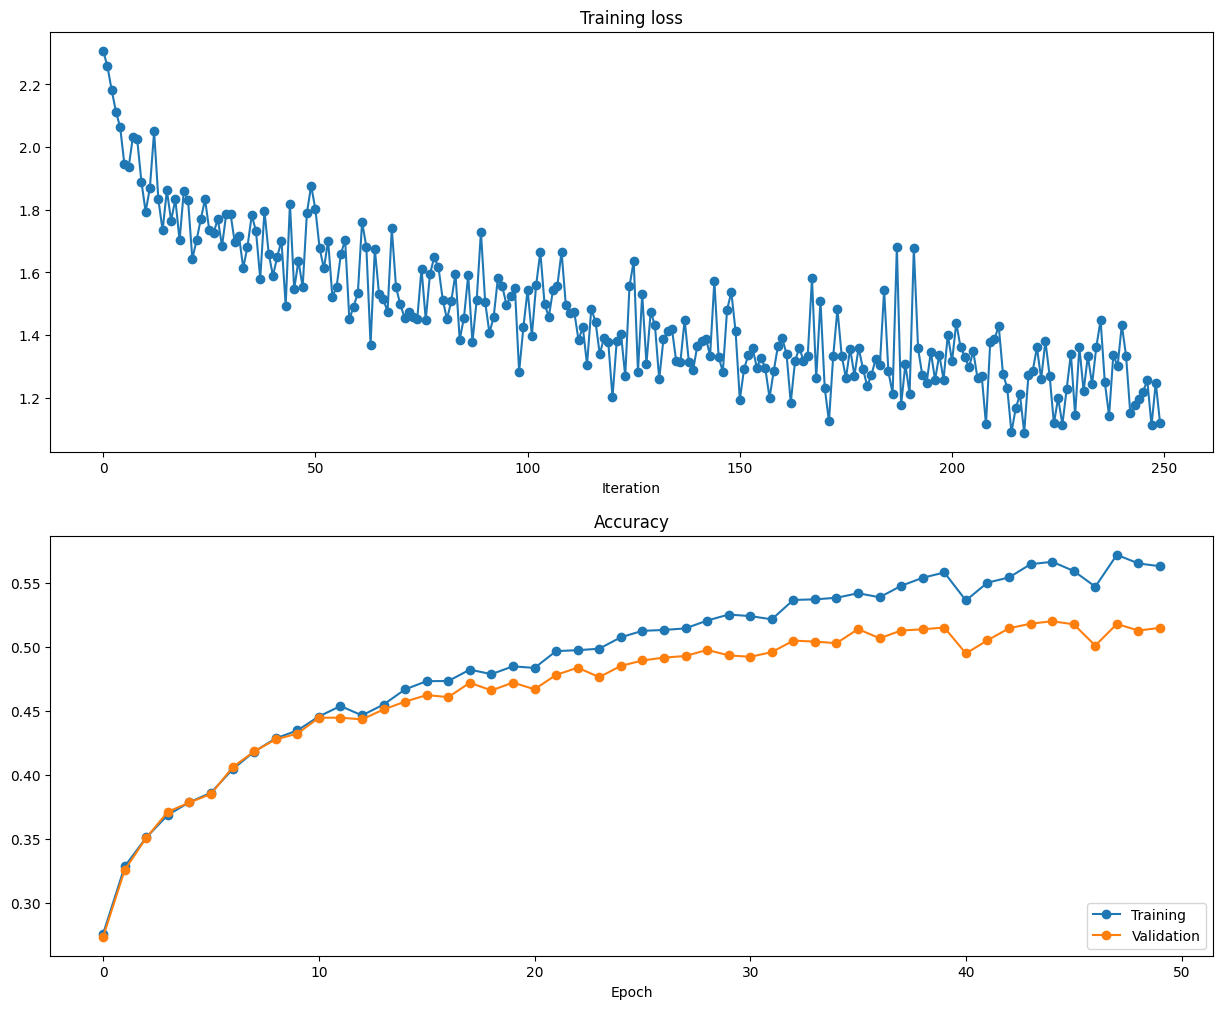

In [128]:
# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100] # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Different Optimizers
There are several more advanced optimizers than vanilla SGD, you will implement three more sophisticated and widely-used methods in this section.  
Please complete the TODOs in the `lib/optim.py`.

## SGD + Momentum 
The update rule of SGD plus momentum is as shown below:  
\begin{align*}
v_t&: \text{last update of the velocity} \\
\gamma&: \text{momentum} \\
\eta&: \text{learning rate} \\
v_t &= \gamma v_{t-1} - \eta \nabla_{\theta}J(\theta) \\
\theta &= \theta + v_t
\end{align*}
The initial value of $v_t$ is $0$.
Complete the `SGDM()` function in `lib/optim.py`.

In [214]:
%reload_ext autoreload

# Test the implementation of SGD with Momentum
seed = 123
np.random.seed(seed=seed)

N, D = 4, 5
test_sgd = sequential(fc(N, D, name="sgd_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

test_sgd.layers[0].params = {"sgd_fc_w": w}
test_sgd.layers[0].grads = {"sgd_fc_w": dw}

test_sgd_momentum = SGDM(test_sgd, 1e-3, 0.9)
test_sgd_momentum.velocity = {"sgd_fc_w": v}
test_sgd_momentum.step()

updated_w = test_sgd.layers[0].params["sgd_fc_w"]
velocity = test_sgd_momentum.velocity["sgd_fc_w"]

expected_updated_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print ('The following errors should be around or less than 1e-8')
print ('updated_w error: ', rel_error(updated_w, expected_updated_w))
print ('velocity error: ', rel_error(expected_velocity, velocity))

The following errors should be around or less than 1e-8
updated_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


## Comparing SGD and SGD with Momentum
Run the following code block to train a multi-layer fully connected network with both SGD and SGD plus Momentum. The network trained with SGDM optimizer should converge faster.


Training with SGD plus Momentum...
(Iteration 1 / 23430) loss: 2.303098573915422
(Iteration 101 / 23430) loss: 2.3022317017028273
(Iteration 201 / 23430) loss: 2.2982815751639425
(Iteration 301 / 23430) loss: 2.2169575937610984
(Iteration 401 / 23430) loss: 2.0262704706891377
(Iteration 501 / 23430) loss: 1.9538937850166485
(Iteration 601 / 23430) loss: 2.2068224394915332
(Iteration 701 / 23430) loss: 1.954856220013799
(Iteration 801 / 23430) loss: 2.1122616282802666
(Iteration 901 / 23430) loss: 2.0631030274614677
(Iteration 1001 / 23430) loss: 1.9612570410543837
(Iteration 1101 / 23430) loss: 1.9254971267632313
(Iteration 1201 / 23430) loss: 2.080692155696717
(Iteration 1301 / 23430) loss: 1.8680183219059912
(Iteration 1401 / 23430) loss: 1.906969981278591
(Iteration 1501 / 23430) loss: 2.059602547621889
(Epoch 1 / 15) Training Accuracy: 0.31852, Validation Accuracy: 0.316375
(Iteration 1601 / 23430) loss: 2.163751205074269
(Iteration 1701 / 23430) loss: 1.8811130855369904
(Iteratio

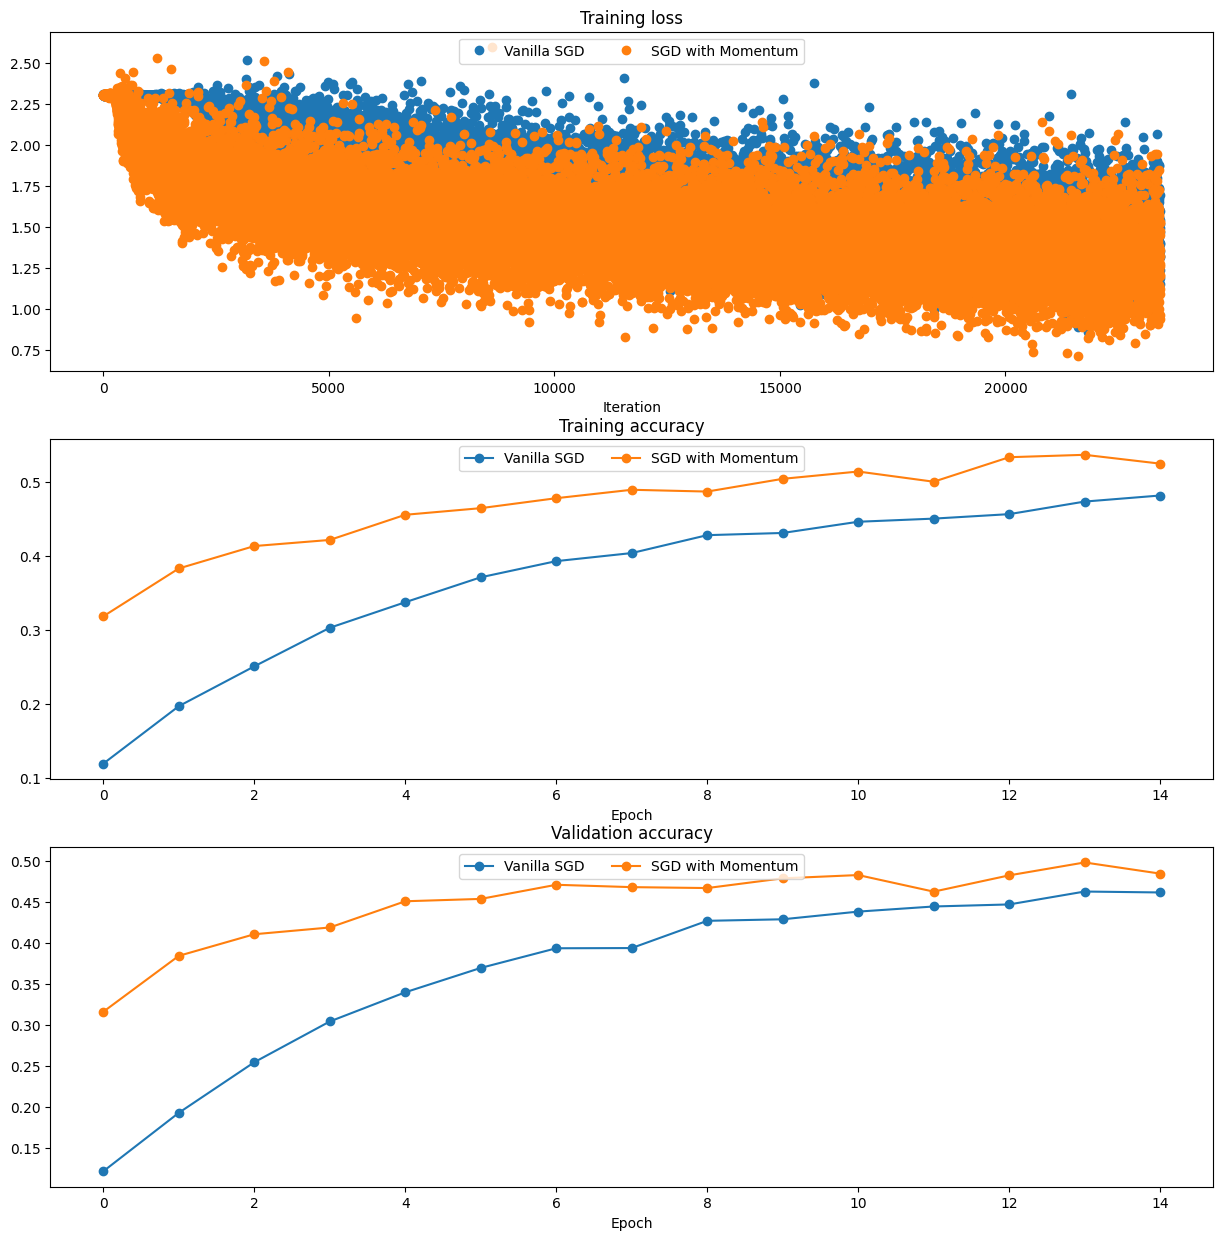

In [213]:
seed = 123
np.random.seed(seed=seed)

# Arrange a small data
num_train = 50000
small_data_dict = {
    "data_train": (data["data_train"][:num_train], data["labels_train"][:num_train]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

model_sgd      = FullyConnectedNetwork()
model_sgdm     = FullyConnectedNetwork()
loss_f_sgd     = cross_entropy()
loss_f_sgdm    = cross_entropy()
optimizer_sgd  = SGD(model_sgd.net, 1e-2)
optimizer_sgdm = SGDM(model_sgdm.net, 1e-2, 0.9)

# print ("Training with Vanilla SGD...")
# results_sgd = train_net(small_data_dict, model_sgd, loss_f_sgd, optimizer_sgd, batch_size=32,
#                         max_epochs=15, show_every=100, verbose=True)

print ("\nTraining with SGD plus Momentum...")
results_sgdm = train_net(small_data_dict, model_sgdm, loss_f_sgdm, optimizer_sgdm, batch_size=32,
                         max_epochs=15, show_every=100, verbose=True)

opt_params_sgd,  loss_hist_sgd,  train_acc_hist_sgd,  val_acc_hist_sgd  = results_sgd
opt_params_sgdm, loss_hist_sgdm, train_acc_hist_sgdm, val_acc_hist_sgdm = results_sgdm

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdm, 'o', label="SGD with Momentum")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdm, '-o', label="SGD with Momentum")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdm, '-o', label="SGD with Momentum")

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## RMSProp 
The update rule of RMSProp is as shown below:  
\begin{align*}
\gamma &: \text{decay rate} \\
\epsilon &: \text{small number} \\
g_t^2 &: \text{squared gradients} \\
\eta &: \text{learning rate} \\
E[g^2]_t &: \text{decaying average of past squared gradients at update step } t \\
E[g^2]_t &= \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 \\
\theta_{t+1} &= \theta_t - \frac{\eta \nabla_{\theta}J(\theta)}{\sqrt{E[g^2]_t+\epsilon}}
\end{align*}
Complete the `RMSProp()` function in `lib/optim.py`

In [209]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

# Test RMSProp implementation; you should see errors less than 1e-7
N, D = 4, 5
test_rms = sequential(fc(N, D, name="rms_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

test_rms.layers[0].params = {"rms_fc_w": w}
test_rms.layers[0].grads = {"rms_fc_w": dw}

opt_rms = RMSProp(test_rms, 1e-2, 0.99)
opt_rms.cache = {"rms_fc_w": cache}
opt_rms.step()

updated_w = test_rms.layers[0].params["rms_fc_w"]
cache = opt_rms.cache["rms_fc_w"]

expected_updated_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('The following errors should be around or less than 1e-7')
print ('updated_w error: ', rel_error(expected_updated_w, updated_w))
print ('cache error: ', rel_error(expected_cache, opt_rms.cache["rms_fc_w"]))

assert rel_error(expected_updated_w, updated_w) < 1e-7
assert rel_error(expected_cache, opt_rms.cache["rms_fc_w"]) < 1e-7

The following errors should be around or less than 1e-7
updated_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


## Adam 
The update rule of Adam is as shown below:  
\begin{align*}
t &= t + 1 \\
g_t &: \text{gradients at update step } t \\
m_t &= \beta_1m_{t-1} + (1-\beta_1)g_t \\
v_t &= \beta_2v_{t-1} + (1-\beta_2)g_t^2 \\
\hat{m_t} &= m_t / (1 - \beta_1^t) \\
\hat{v_t} &= v_t / (1 - \beta_2^t) \\
\theta_{t+1} &= \theta_t - \frac{\eta\ \hat{m_t}}{\sqrt{\hat{v_t}}+\epsilon} \\
\end{align*}
Complete the `Adam()` function in `lib/optim.py`
Important Notes:
1) $t$ must be updated before everything else
2) $\beta_1^t$ is $\beta_1$ exponentiated to the $t$'th power

In [215]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

# Test Adam implementation; you should see errors around 1e-7 or less
N, D = 4, 5
test_adam = sequential(fc(N, D, name="adam_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

test_adam.layers[0].params = {"adam_fc_w": w}
test_adam.layers[0].grads = {"adam_fc_w": dw}

opt_adam = Adam(test_adam, 1e-2, 0.9, 0.999, t=5)
opt_adam.mt = {"adam_fc_w": m}
opt_adam.vt = {"adam_fc_w": v}
opt_adam.step()

updated_w = test_adam.layers[0].params["adam_fc_w"]
mt = opt_adam.mt["adam_fc_w"]
vt = opt_adam.vt["adam_fc_w"]

expected_updated_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print ('The following errors should be around or less than 1e-7')
print ('updated_w error: ', rel_error(expected_updated_w, updated_w))
print ('mt error: ', rel_error(expected_m, mt))
print ('vt error: ', rel_error(expected_v, vt))

assert rel_error(expected_updated_w, updated_w)<1e-6
assert rel_error(expected_m, mt)<1e-7
assert rel_error(expected_v, vt)<1e-7

The following errors should be around or less than 1e-7
updated_w error:  1.1395691798535431e-07
mt error:  4.214963193114416e-09
vt error:  4.208314038113071e-09


## Comparing the optimizers
Run the following code block to compare the plotted results among all the above optimizers. You should see SGD with Momentum, RMSProp, and Adam optimizers work better than Vanilla SGD optimizer.

Training with RMSProp...
(Iteration 1 / 23430) loss: 2.3001708119669724
(Iteration 101 / 23430) loss: 2.069310765992511
(Iteration 201 / 23430) loss: 2.0704545018251648
(Iteration 301 / 23430) loss: 2.0216460809554118
(Iteration 401 / 23430) loss: 1.8127732887102186
(Iteration 501 / 23430) loss: 1.8116081513244122
(Iteration 601 / 23430) loss: 1.9667014080564724
(Iteration 701 / 23430) loss: 2.0003096630758446
(Iteration 801 / 23430) loss: 1.9640242058144435
(Iteration 901 / 23430) loss: 1.9539258396451058
(Iteration 1001 / 23430) loss: 1.8955580376262806
(Iteration 1101 / 23430) loss: 2.1789929952794473
(Iteration 1201 / 23430) loss: 1.9041486523843327
(Iteration 1301 / 23430) loss: 1.7052613719436316
(Iteration 1401 / 23430) loss: 1.8478674575462044
(Iteration 1501 / 23430) loss: 2.16241953857801
(Epoch 1 / 15) Training Accuracy: 0.35286, Validation Accuracy: 0.352
(Iteration 1601 / 23430) loss: 1.7509917350359956
(Iteration 1701 / 23430) loss: 1.7566956914502372
(Iteration 1801 / 23

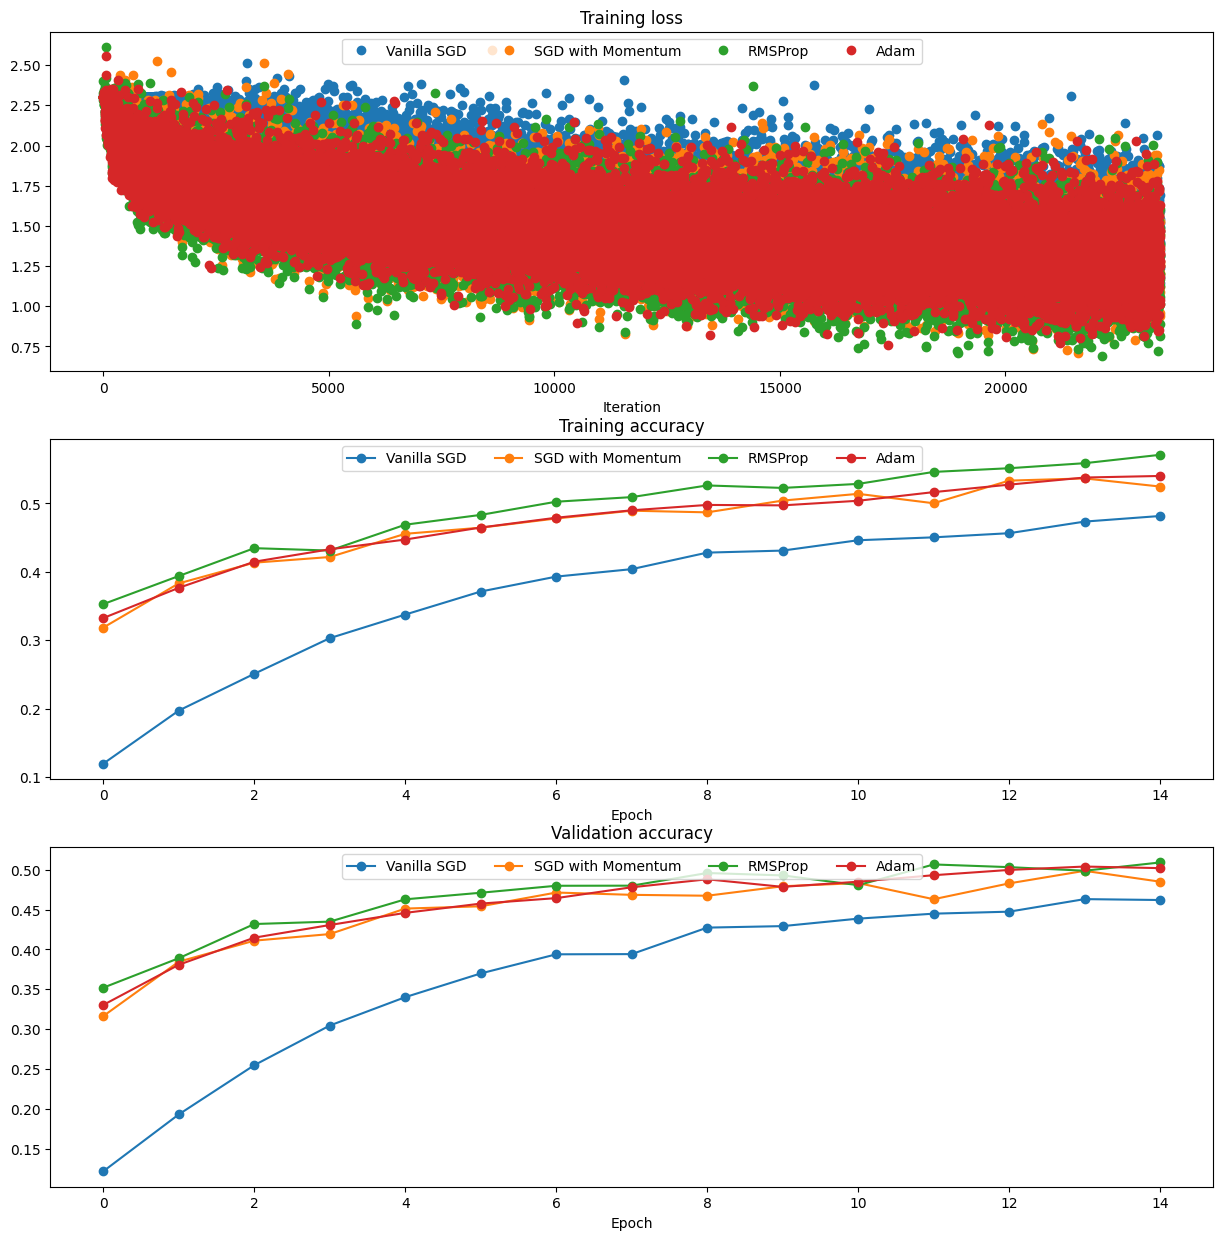

In [218]:
seed = 123
np.random.seed(seed=seed)

model_rms      = FullyConnectedNetwork()
model_adam     = FullyConnectedNetwork()
loss_f_rms     = cross_entropy()
loss_f_adam    = cross_entropy()
optimizer_rms  = RMSProp(model_rms.net, 5e-4)
optimizer_adam = Adam(model_adam.net, 5e-4)

print ("Training with RMSProp...")
results_rms = train_net(small_data_dict, model_rms, loss_f_rms, optimizer_rms, batch_size=32,
                        max_epochs=15, show_every=100, verbose=True)

print ("\nTraining with Adam...")
results_adam = train_net(small_data_dict, model_adam, loss_f_adam, optimizer_adam, batch_size=32,
                         max_epochs=15, show_every=100, verbose=True)

opt_params_rms,  loss_hist_rms,  train_acc_hist_rms,  val_acc_hist_rms  = results_rms
opt_params_adam, loss_hist_adam, train_acc_hist_adam, val_acc_hist_adam = results_adam

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdm, 'o', label="SGD with Momentum")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdm, '-o', label="SGD with Momentum")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdm, '-o', label="SGD with Momentum")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_rms, 'o', label="RMSProp")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_rms, '-o', label="RMSProp")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_rms, '-o', label="RMSProp")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_adam, 'o', label="Adam")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_adam, '-o', label="Adam")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_adam, '-o', label="Adam")

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Plot the Activation Functions
In each of the activation function, use the given lambda function template to plot their corresponding curves.

\begin{align*}
1.\ \textbf{Sigmoid Function:}\ & \sigma(x) = \frac{1}{1 + e^{-x}} \\
2.\ \textbf{Leaky ReLU (Rectified Linear Unit):}\ & 
   \begin{cases} 
      f(x) = x & \text{if } x > 0 \\
      f(x) = \alpha x & \text{otherwise} 
   \end{cases} \\
3.\ \textbf{ReLU (Rectified Linear Unit):}\ & f(x) = \max(0, x) \\
4.\ \textbf{ELU (Exponential Linear Unit):}\ &
   \begin{cases} 
      f(x) = x & \text{if } x > 0 \\
      f(x) = \alpha(e^x - 1) & \text{otherwise} 
   \end{cases} \\
5.\ \textbf{SELU (Scaled Exponential Linear Unit):}\ &
   \begin{cases} 
      f(x) = \lambda x & \text{if } x > 0 \\
      f(x) = \lambda(\alpha e^x - \alpha) & \text{otherwise} 
   \end{cases} \\
6.\ \textbf{Tanh (Hyperbolic Tangent):}\ & f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
\end{align*}



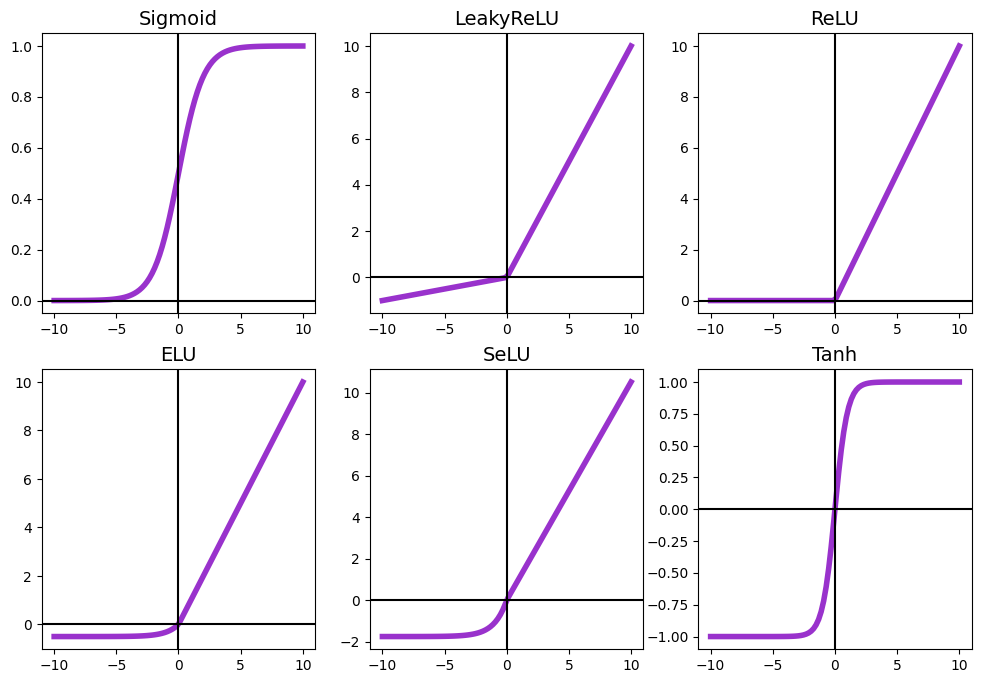

In [185]:
left, right = -10, 10
X  = np.linspace(left, right, 100)
XS = np.linspace(-5, 5, 10)
lw = 4
alpha = 0.1 # alpha for leaky_relu
elu_alpha = 0.5
selu_alpha = 1.6732
selu_scale = 1.0507

###################
# TODO: YOUR CODE #
###################
sigmoid = lambda x: 1 / (1 + np.exp(-x))
leaky_relu = lambda x: np.where(x > 0, x, alpha * x)
relu = lambda x: np.maximum(0, x)
elu = lambda x: np.where(x > 0, x, elu_alpha * (np.exp(x) - 1))
selu = lambda x: selu_scale * np.where(x > 0, x, selu_alpha * (np.exp(x) - 1))
tanh = lambda x: np.tanh(x)
####################
# END OF YOUR CODE #
####################

activations = {
    "Sigmoid": sigmoid,
    "LeakyReLU": leaky_relu,
    "ReLU": relu,
    "ELU": elu,
    "SeLU": selu,
    "Tanh": tanh
}

# Ground Truth activations
GT_Act = {
    "Sigmoid": [0.00669285092428, 0.0200575365379, 0.0585369028744, 0.158869104881, 0.364576440742,
                0.635423559258, 0.841130895119, 0.941463097126, 0.979942463462, 0.993307149076],
    "LeakyReLU": [-0.5, -0.388888888889, -0.277777777778, -0.166666666667, -0.0555555555556,
                  0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "ReLU": [-0.0, -0.0, -0.0, -0.0, -0.0, 0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "ELU": [-0.4966310265, -0.489765962143, -0.468911737989, -0.405562198581, -0.213123289631,
            0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "SeLU": [-1.74618571868, -1.72204772347, -1.64872296837, -1.42598202974, -0.749354802287,
             0.583722222222, 1.75116666667, 2.91861111111, 4.08605555556, 5.2535],
    "Tanh": [-0.999909204263, -0.999162466631, -0.992297935288, -0.931109608668, -0.504672397722,
             0.504672397722, 0.931109608668, 0.992297935288, 0.999162466631, 0.999909204263]
}

fig = plt.figure(figsize=(12,8))
for i, label in enumerate(activations):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(X, activations[label](X), color='darkorchid', lw=lw, label=label)
    assert rel_error(activations[label](XS), GT_Act[label]) < 1e-9, \
           "Your implementation of {} might be wrong".format(label)
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title('{}'.format(label), fontsize=14)
plt.show()

# Submission

Complete the required code and run ALL the code cells in this notebook. 
Submit the files mentioned in the README.